In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih, openalex
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

import re
import matplotlib.dates as mdates

In [2]:
sources_index = pd.read_csv('../data/sources_scopus_wos_indexing_240418.csv')

In [3]:
paper_mill_df = pd.read_csv('../data/paper_mill_dois_240418.csv')

paper_mill_df['doi'] = paper_mill_df['doi'].astype(str).apply(lambda x: 'https://doi.org/' + x).values

doi_list = paper_mill_df['doi'].values

In [4]:
%%time
works = openalex.works(
            dataset = 'main', 
            filters={'doi': doi_list})

CPU times: total: 2min 33s
Wall time: 2min 45s


In [5]:
works = pd.merge(works, paper_mill_df, how='inner', on='doi')

In [6]:
works = pd.merge(works, sources_index, how='left', on='source_id')

In [7]:
works['after_scopus_deindex'] = works['year'] >= works['scopus_last_year']
works['after_wos_deindex'] = works['year'] >= works['wos_last_year']
works['after_pubmed_deindex'] = works['year'] >= works['pubmed_last_year']

In [8]:
rw_db = pd.read_csv('../data/240304_retraction_watch_db.csv', encoding='latin')
rw_db = rw_db[(rw_db['RetractionNature'] == 'Retraction')]
rw_db['OriginalPaperDOI'] = rw_db['OriginalPaperDOI'].astype(str).str.lower()
rw_db['doi'] = rw_db['OriginalPaperDOI'].astype(str).apply(lambda x: 'https://doi.org/' + x).values

In [9]:
works_slice = works.drop_duplicates('work_id')

works_slice = pd.merge(works_slice, rw_db, on='doi', how='left')

In [10]:
works_slice['retracted'] = works_slice['RetractionNature'] == 'Retraction'

In [12]:
works_slice['retraction_date'] = pd.to_datetime(works_slice['RetractionDate'])

In [13]:
works_slice['retraction_year'] = [x.year for x in works_slice['retraction_date']]

In [14]:
works_slice['retraction_delay'] = works_slice['retraction_year'] - works_slice['year']
works_slice['wos_delay'] = works_slice['wos_last_year'] - works_slice['year']
works_slice['scopus_delay'] = works_slice['scopus_last_year'] - works_slice['year']
works_slice['pubmed_delay'] = works_slice['pubmed_last_year'] - works_slice['year']

In [15]:
works_slice['pubmed_deindexed'] = works_slice['pubmed'] & ~works_slice['pubmed_last_year'].isna()
works_slice['wos_deindexed'] = works_slice['wos'] & ~works_slice['wos_last_year'].isna()
works_slice['scopus_deindexed'] = works_slice['scopus'] & ~works_slice['scopus_last_year'].isna()

In [16]:
def get_censoring_curve(delay_series):
    
    '''
    Takes an array of years between publication and
    penalty, creates a cumulative proportional distribution
    to be used to correct for censoring.
    '''
    bins = np.arange(np.min(delay_series), np.max(delay_series)+2, 1)
    hist_count, hist_bins = np.histogram(delay_series, bins=bins)

    hist_bins = hist_bins[:-1]
    cum_count = hist_count.cumsum()
    tot = hist_count.sum()
    p = cum_count/tot
    se = np.sqrt(p*(1-p)/tot)

    return hist_bins, p, se

In [17]:
hist_bins, p, se = get_censoring_curve(delay_series = works_slice['pubmed_delay'])

In [18]:
def get_count_array_index(service='pubmed', eval_year=2023):
    
    '''
    Generates censor-corrected data for de-indexing.
    
    '''

    delay_series = works_slice[service+'_delay']

    hist_bins, p, se = get_censoring_curve(delay_series[delay_series > 0])

    count_array = works_slice[works_slice[service] == True].groupby(['year',service+'_deindexed']).count()

    count_array = count_array.reset_index()[['year', service+'_deindexed', 'work_id']]\
    .pivot(index='year', columns=service+'_deindexed', values='work_id').fillna(0.0).reset_index()
    count_array['time_from_eval_year'] = eval_year - count_array['year']


    p_penalized_array = []
    se_penalized_array = []

    for index, row in count_array.iterrows():
        time_from_eval_year = row['time_from_eval_year']
        count_penalized = row[True]
        try:
            p_penalized = p[hist_bins <= time_from_eval_year][-1]
            se_penalized = se[hist_bins <= time_from_eval_year][-1]
        except:
            p_penalized = 1.0
            se_penalized = 0.0

        p_penalized_array.append(p_penalized)
        se_penalized_array.append(se_penalized)

    count_array['p_penalized'] = p_penalized_array
    count_array['se_penalized'] = se_penalized_array
    count_array['tot'] = count_array[True] + count_array[False]
    count_array['censor_corrected'] = count_array[True]/(count_array['p_penalized'])
    count_array['censor_corrected_p975'] = count_array[True]/(count_array['p_penalized']-1.96*count_array['se_penalized'])
    count_array['censor_corrected_p025'] = count_array[True]/(count_array['p_penalized']+1.96*count_array['se_penalized'])
    
    return count_array

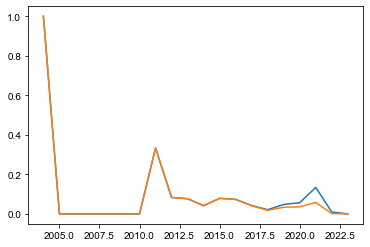

In [19]:
count_array = get_count_array_index(service='pubmed', eval_year=2023)

plt.plot(count_array['year'], count_array['censor_corrected']/count_array['tot'])
plt.plot(count_array['year'], count_array[True]/count_array['tot'])

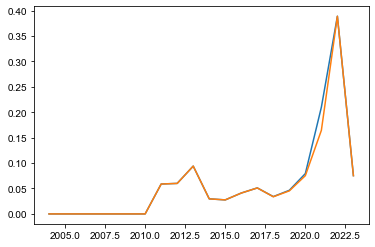

In [20]:
count_array = get_count_array_index(service='scopus', eval_year=2022)

plt.plot(count_array['year'], count_array['censor_corrected']/count_array['tot'])
plt.plot(count_array['year'], count_array[True]/count_array['tot'])

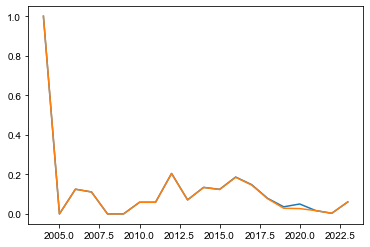

In [21]:
count_array = get_count_array_index(service='wos', eval_year=2021)

plt.plot(count_array['year'], count_array['censor_corrected']/count_array['tot'])
plt.plot(count_array['year'], count_array[True]/count_array['tot'])

In [22]:
def get_count_array_retract(eval_year=2022):
    
    '''
    Generates censor-corrected data for de-indexing.
    
    '''

    delay_series = works_slice['retraction_delay']

    hist_bins, p, se = get_censoring_curve(delay_series[delay_series > 0])

    count_array = works_slice.groupby(['year','retracted']).count()

    count_array = count_array.reset_index()[['year', 'retracted', 'work_id']]\
    .pivot(index='year', columns='retracted', values='work_id').fillna(0.0).reset_index()
    count_array['time_from_eval_year'] = eval_year - count_array['year']


    p_penalized_array = []
    se_penalized_array = []

    for index, row in count_array.iterrows():
        time_from_eval_year = row['time_from_eval_year']
        count_penalized = row[True]
        try:
            p_penalized = p[hist_bins <= time_from_eval_year][-1]
            se_penalized = se[hist_bins <= time_from_eval_year][-1]
        except:
            p_penalized = 1.0
            se_penalized = 0.0

        p_penalized_array.append(p_penalized)
        se_penalized_array.append(se_penalized)

    count_array['p_penalized'] = p_penalized_array
    count_array['se_penalized'] = se_penalized_array
    count_array['tot'] = count_array[True] + count_array[False]
    count_array['censor_corrected'] = count_array[True]/(count_array['p_penalized'])
    count_array['censor_corrected_p975'] = count_array[True]/(count_array['p_penalized']-1.96*count_array['se_penalized'])
    count_array['censor_corrected_p025'] = count_array[True]/(count_array['p_penalized']+1.96*count_array['se_penalized'])
    
    return count_array

C:\Users\richa\AppData\Local\Temp\ipykernel_23344\3670693548.py:61: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(bottom=0)
meta NOT subset; don't know how to subset; dropped


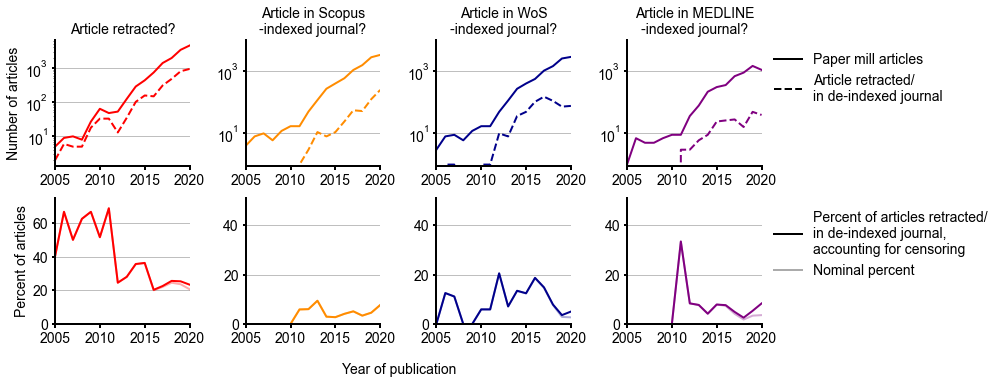

In [23]:
linewidth=2
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(14,5))


#retractions
count_array = get_count_array_retract(eval_year=2023)
count_array['p_retracted'] = count_array['censor_corrected']/count_array['tot']
count_array['p_retracted_p975'] = count_array['censor_corrected_p975']/count_array['tot']
count_array['p_retracted_p025'] = count_array['censor_corrected_p025']/count_array['tot']
count_array = count_array[(count_array['year'] <= 2020) & (count_array['year'] >= 2005)]

ax = axes[0][0]
# plot of total paper mills and retracted paper mills
ax.plot(count_array['year'], count_array['tot'], color='red', linewidth=linewidth)
ax.plot(count_array['year'], count_array[True], color='red', linestyle='dashed', linewidth=linewidth)
ax.set_yscale('log')

# plot of percent of retractions
ax = axes[1][0]
ax.plot(count_array['year'], 100*count_array[True]/count_array['tot'], color='red', alpha=0.33, linewidth=linewidth)
ax.plot(count_array['year'], 100*count_array['p_retracted'], color='red', linewidth=linewidth)
ax.set_ylim([0,75])
'''
ax.fill_between(x=count_array['year'], 
                y1=100*count_array['p_retracted_p025'], 
                y2=100*count_array['p_retracted_p975'], 
                alpha=0.25, color='red', linewidth=0)
'''

# indexing
for service, color, eval_year, ax_index in zip(['scopus','wos', 'pubmed'], 
                          ['darkorange', 'darkblue', 'purple'], 
                                     [2023, 2021, 2022], [1,2,3]):
    
    count_array = get_count_array_index(service=service, eval_year=eval_year)
    count_array['p_retracted'] = count_array['censor_corrected']/count_array['tot']
    count_array['p_retracted_p975'] = count_array['censor_corrected_p975']/count_array['tot']
    count_array['p_retracted_p025'] = count_array['censor_corrected_p025']/count_array['tot']
    count_array = count_array[(count_array['year'] <= 2020) & (count_array['year'] >= 2005)]
    
    ax = axes[0][ax_index]
    ax.plot(count_array['year'], count_array['tot'], color=color, linewidth=linewidth)
    ax.plot(count_array['year'], count_array[True], color=color, linestyle='dashed', linewidth=linewidth)
    ax.set_yscale('log')
    ax.set_ylim([0.9, 10_000])
    
    ax = axes[1][ax_index]
    ax.plot(count_array['year'], 100*count_array['p_retracted'], color=color, linewidth=linewidth)
    ax.plot(count_array['year'], 100*count_array[True]/count_array['tot'], color=color, alpha=0.33, linewidth=linewidth)
    '''
    ax.fill_between(x=count_array['year'], 
                    y1=100*count_array['p_retracted_p025'], 
                    y2=100*count_array['p_retracted_p975'], 
                    alpha=0.25, color=color, linewidth=0)
                    
    '''
    ax.set_ylim([0,51])
    
for ax in axes.flatten():
    ax.set_xlim([2005, 2020.])
    ax.set_ylim(bottom=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    [ax.spines[i].set_linewidth(2) for i in ax.spines]
    ax.tick_params(labelsize=14, axis='both', width=linewidth)
    ax.grid(axis='y')

axes[0][0].set_title('Article retracted?', fontsize=14)
axes[0][1].set_title('Article in Scopus\n-indexed journal?', fontsize=14)
axes[0][2].set_title('Article in WoS\n-indexed journal?', fontsize=14)
axes[0][3].set_title('Article in MEDLINE\n-indexed journal?', fontsize=14)

axes[0][0].set_ylabel('Number of articles', fontsize=14)
axes[1][0].set_ylabel('Percent of articles', fontsize=14)

axes[0][3].plot([], [], color='k', linewidth=linewidth, label='Paper mill articles')
axes[0][3].plot([], [], color='k', linewidth=linewidth, linestyle='dashed', label='Article retracted/\nin de-indexed journal')
axes[0][3].legend(fontsize=14, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

axes[1][3].plot([], [], color='k', linewidth=linewidth, label='Percent of articles retracted/\nin de-indexed journal,\naccounting for censoring')
axes[1][3].plot([], [], color='k', linewidth=linewidth, alpha=0.33, label='Nominal percent')
axes[1][3].legend(fontsize=14, bbox_to_anchor=(1,1), frameon=False, loc='upper left')

fig.text(s='Year of publication', ha='center', x=0.4, y=-0.05, fontsize=14)
fig.tight_layout()

plt.savefig('../img/240501_percent_retracted_deindexed.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/240501_percent_retracted_deindexed.pdf', bbox_inches='tight')

In [25]:
year_df = pd.read_csv('../data/openalex_summary_by_year_230502.csv')